# Convolution Neural Networks - MNIST Dataset - Parallel

> Joseph P. Vantassel, Texas Advanced Computing Center - The University of Texas at Austin


In [ ]:
# If you have not done so previously.
!pip install -r requirements.txt

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

mpl.rcParams["font.size"]=8

## Import and Visualize Data

In [2]:
data = keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = data

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


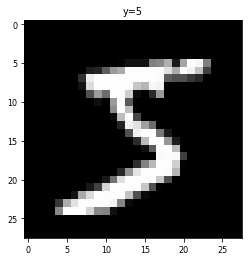

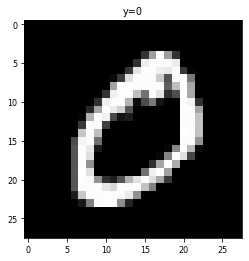

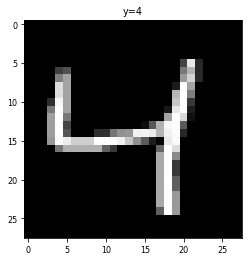

In [4]:
for idx in range(3):
    plt.imshow(x_train[idx], cmap="binary_r")
    plt.title(f"y={y_train[idx]}")
    plt.show()

## Preprocess

### Image Preperation

- Calculate mean and std and store for later.
- Normalize image inputs.

In [5]:
x_mean, x_std = np.mean(x_train), np.std(x_train)
print(f"mean={x_mean:.2f}, std={x_std:.2f}")
x_train_norm = (x_train - x_mean)/x_std
print(f"mean={np.mean(x_train_norm):.2f}, std={np.std(x_train_norm):.2f}")

mean=33.32, std=78.57
mean=-0.00, std=1.00


### Output Preperation

- One-hot encoding

In [6]:
y_train_one_hot = np.zeros((y_train.size, 10), dtype=int)
for row, col in enumerate(y_train):
    y_train_one_hot[row, col] = 1

### Check

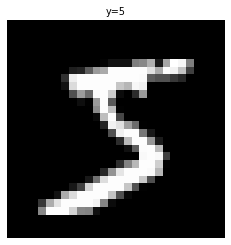

5 [0 0 0 0 0 1 0 0 0 0]


In [7]:
idx = 0
plt.imshow(x_train_norm[idx], cmap="binary_r")
plt.axis("off")
plt.title(f"y={y_train[idx]}")
plt.show()
print(y_train[idx], y_train_one_hot[idx])

## Develop Network Architecture

For parallel training, add `mirrored_strategy` context.

In [8]:
mirrored_strategy = tf.distribute.MirroredStrategy([f"GPU:{x}" for x in range(4)])

def get_model():
    with mirrored_strategy.scope():
        inputs = keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, kernel_size=3, strides=2, activation="relu")(inputs)
        x = layers.Conv2D(64, kernel_size=3, activation="relu")(x)
        x = layers.Conv2D(64, kernel_size=3, activation="relu")(x)
        x = layers.Conv2D(10, kernel_size=3, activation="relu")(x)
        b, h, w, c = x.shape
        x = layers.AveragePooling2D(pool_size=(h, w))(x)
        x = layers.Flatten()(x)
        model = keras.Model(inputs, x)
    return model
model = get_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


### Define Loss Function

- Categorical Cross Entropy on Logits

In [9]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0, reduction="auto")

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [11]:
model.compile(optimizer=optimizer, loss=loss)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 10)          5770      
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 10)         0         
 ooling2D)                                                       
                                                             

In [13]:
# Hyperparameters
batch_size = 64
epochs = 10
validation_split = 0.2

history = model.fit(x_train_norm, y_train_one_hot, validation_split=validation_split, epochs=epochs)

Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/

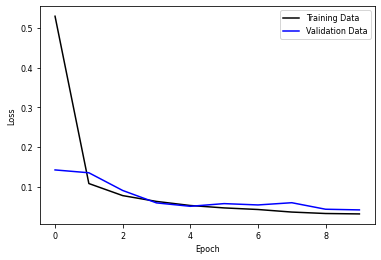

In [14]:
plt.plot(history.epoch, history.history["loss"], color="black", label="Training Data")
plt.plot(history.epoch, history.history["val_loss"], color="blue", label="Validation Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### View Results

In [15]:
y_test_predicted = model.predict((x_test - x_mean)/x_std)
y_test_prob = keras.layers.Softmax(axis=-1)(y_test_predicted)

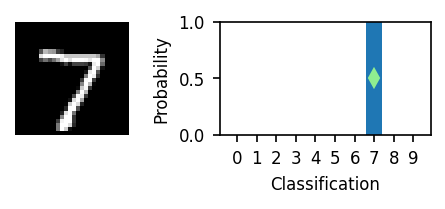

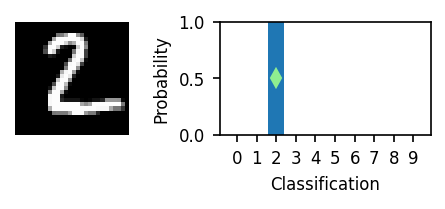

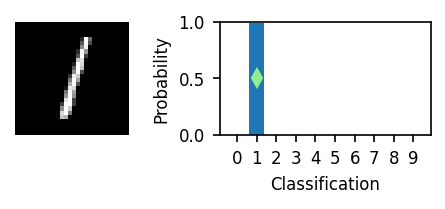

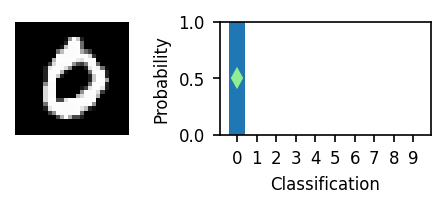

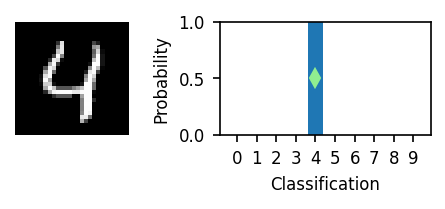

In [16]:
for idx in range(5):
    fig, axs = plt.subplots(ncols=2, figsize=(4, 1), dpi=150)
    ax = axs[0]
    ax.imshow(x_test[idx], cmap="binary_r")
    ax.axis("off")

    ax = axs[1]
    ax.bar(np.arange(10), y_test_prob[idx])
    ax.set_xticks(range(10))
    ax.plot(y_test[idx], 0.5, marker="d", color="lightgreen")
    ax.set_xticks(range(10))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Classification")
    ax.set_ylabel("Probability")
    plt.show()

## Calculate Prediction Accuracy

In [17]:
y_pred = np.argmax(y_test_prob, axis=-1)
accuracy = np.sum(y_test == y_pred)/len(y_pred)
print(f"Test Accuracy: {accuracy*100:.1f}%")

Test Accuracy: 98.8%


## Failed Predictions

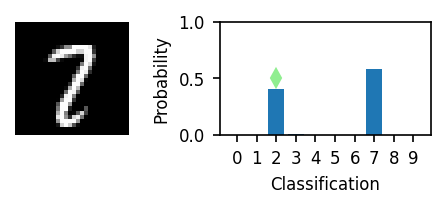

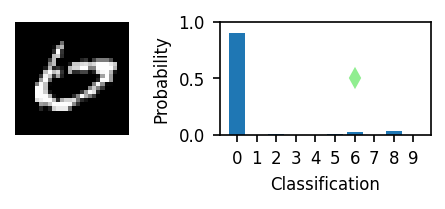

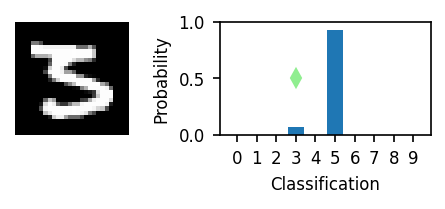

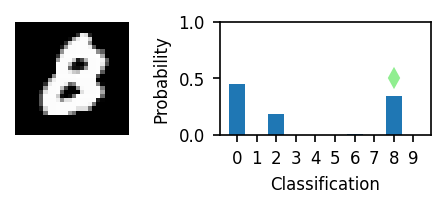

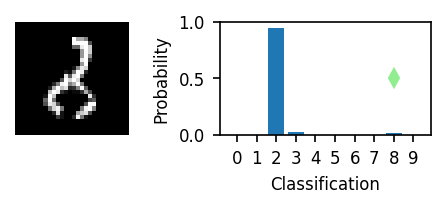

In [18]:
idxs = np.argwhere(y_test != y_pred).flatten()

nidxs = 5
count = 0
for idx in idxs:
    fig, axs = plt.subplots(ncols=2, figsize=(4, 1), dpi=150)
    ax = axs[0]
    ax.imshow(x_test[idx], cmap="binary_r")
    ax.axis("off")

    ax = axs[1]
    ax.bar(np.arange(10), y_test_prob[idx])
    ax.plot(y_test[idx], 0.5, marker="d", color="lightgreen")
    ax.set_xticks(range(10))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Classification")
    ax.set_ylabel("Probability")
    plt.show()
    count += 1
    
    if count == nidxs:
        break